In [5]:
import os
import pickle
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import warnings
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import re
from collections import defaultdict, Counter

In [6]:
df = pd.read_csv('data.csv')


In [9]:
def word_cloud(genre):
    df_genre = df.loc[df['genre']==genre]
    text = ' '.join(genre for genre in df_genre.synopsis)
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.savefig(f'{genre}.pdf',bbox_inches='tight')
    plt.axis("off")
    plt.title(genre.capitalize(),fontsize=28)
    plt.show()

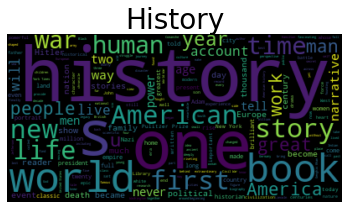

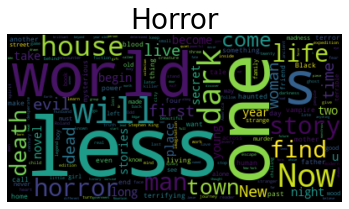

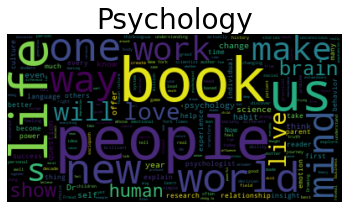

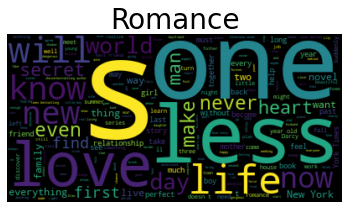

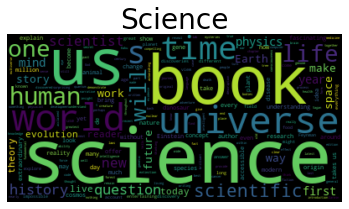

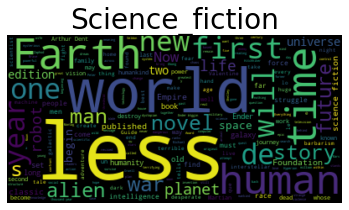

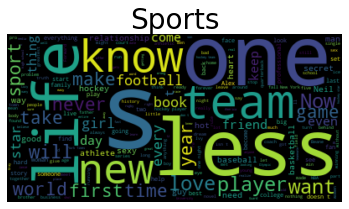

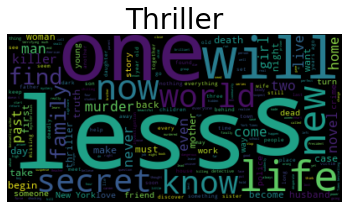

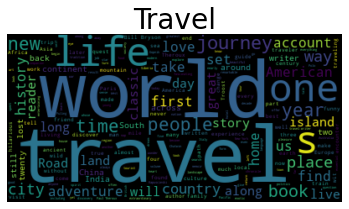

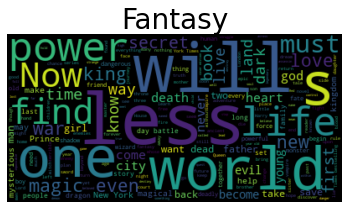

In [10]:
genres = df['genre'].unique()
for genre in genres:
    word_cloud(genre)

In [11]:
# Create a new column 'category_id' with encoded categories 
df['category_id'] = df['genre'].factorize()[0]
category_id_df = df[['genre', 'category_id']].drop_duplicates()
display(category_id_df)

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'genre']].values)

,genre,category_id
0,history,0
99,horror,1
199,psychology,2
298,romance,3
409,science,4
488,science_fiction,5
533,sports,6
612,thriller,7
1093,travel,8
1191,fantasy,9


# Visualize the data using Bar chart (BRUGES FLERE GANGE, HVIS VI SLÅR AFPRØVNINGER SAMMEN)

genre
fantasy            348
history             99
horror             100
psychology          99
romance            111
science             79
science_fiction     45
sports              79
thriller           481
travel              98
Name: genre, dtype: int64

<Figure size 576x432 with 0 Axes>

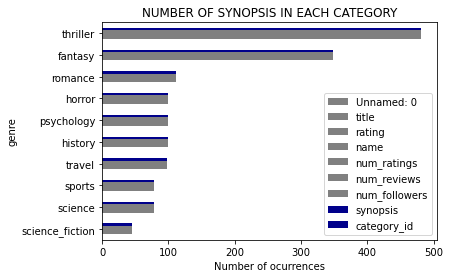

In [12]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','darkblue','darkblue','darkblue']
df.groupby('genre').count().sort_values(['category_id']).plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF SYNOPSIS IN EACH CATEGORY')
plt.xlabel('Number of ocurrences', fontsize = 10);

display(df.groupby('genre')['genre'].count())



In [20]:
tfidf = TfidfVectorizer(use_idf=True, sublinear_tf=True, min_df=5)

features = tfidf.fit_transform(df.synopsis).toarray()
labels = df.category_id

In [21]:
X = df['synopsis'] # Collection of 'clean synopsis'
y = df['genre'] # Target or the labels we want to predict (i.e., the 10 different genres)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    random_state = 1)

In [22]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=6, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, solver = 'liblinear', C=10, penalty = 'l2'),
]

In [23]:
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [24]:
from sklearn.model_selection import cross_validate
entries = []
#models = [RandomForestClassifier(n_estimators=200, max_depth=16, random_state=0, max_features="sqrt")]

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
display(cv_df)

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.425325
1,RandomForestClassifier,1,0.428571
2,RandomForestClassifier,2,0.405844
3,RandomForestClassifier,3,0.431818
4,RandomForestClassifier,4,0.423453
5,LinearSVC,0,0.792208
6,LinearSVC,1,0.779221
7,LinearSVC,2,0.756494
8,LinearSVC,3,0.740260
9,LinearSVC,4,0.765472


In [25]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.766731,0.020076
LogisticRegression,0.745283,0.021697
MultinomialNB,0.469125,0.019377
RandomForestClassifier,0.423002,0.010109


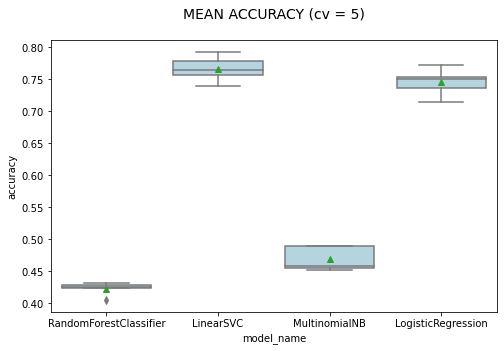

In [26]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [28]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.20, 
                                                               random_state=1)

model = LinearSVC()
model.fit(X_train, y_train)
y_pred_linearSVC = model.predict(X_test)

model = LogisticRegression(random_state=0, solver = 'liblinear', C=10, penalty = 'l2')
model.fit(X_train, y_train)
y_pred_logisticRegression = model.predict(X_test)
proba_logisticRegression = model.predict_proba(X_test)

model = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=0, max_features="sqrt")
model.fit(X_train, y_train)
y_pred_RFC = model.predict(X_test) 

In [29]:
# Classification report
names = ["linearSVC", "logisticRegression", "RandomForest"]
for name, y_pred in zip(names, [y_pred_linearSVC, y_pred_logisticRegression, y_pred_RFC]):
  print(f'\t{name} CLASSIFICATIION METRICS\n')
  print(metrics.classification_report(y_test, y_pred, target_names= df['genre'].unique()))
  print()

	linearSVC CLASSIFICATIION METRICS

                 precision    recall  f1-score   support

        history       0.78      0.78      0.78        18
         horror       0.44      0.20      0.28        20
     psychology       1.00      0.77      0.87        22
        romance       0.60      0.50      0.55        18
        science       0.79      0.92      0.85        12
science_fiction       1.00      0.33      0.50         9
         sports       1.00      0.82      0.90        17
       thriller       0.76      0.93      0.83       108
         travel       0.93      0.93      0.93        15
        fantasy       0.86      0.88      0.87        69

       accuracy                           0.80       308
      macro avg       0.82      0.71      0.74       308
   weighted avg       0.80      0.80      0.79       308


	logisticRegression CLASSIFICATIION METRICS

                 precision    recall  f1-score   support

        history       0.78      0.78      0.78        18
  

C:\Users\rasmu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rasmu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rasmu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
def plot_confusion(y_test, y_pred, title, figsize=(8,8)):
  conf_mat = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=figsize)
  sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
              xticklabels=category_id_df.genre.values, 
              yticklabels=category_id_df.genre.values)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title(f"{title}", size=16);

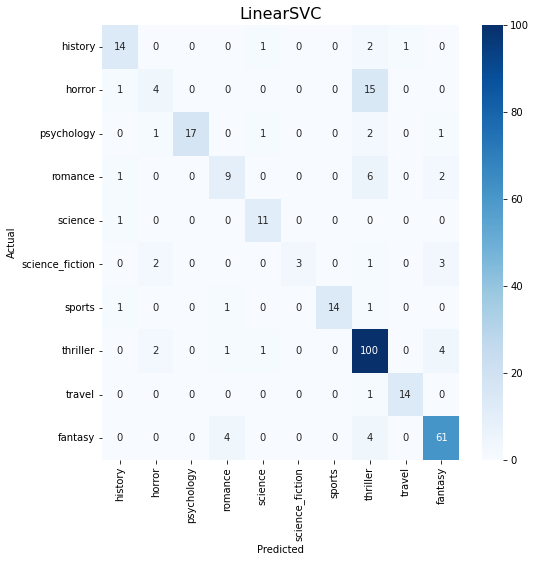

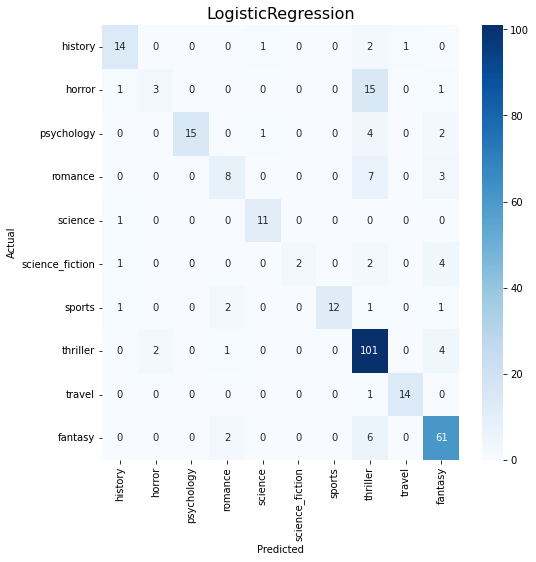

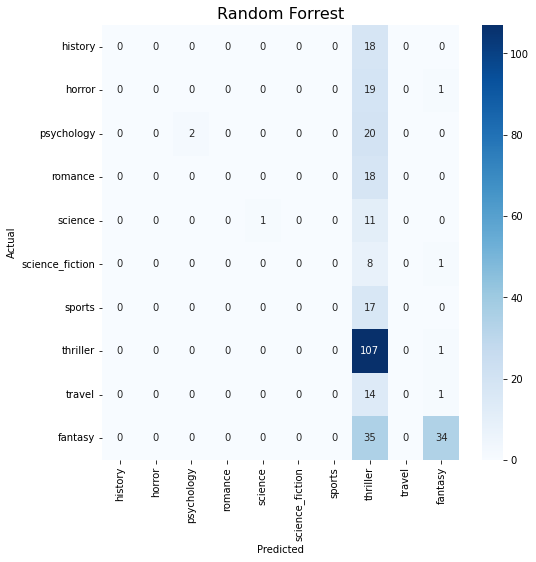

In [32]:
plot_confusion(y_test, y_pred_linearSVC, "LinearSVC")
plot_confusion(y_test, y_pred_logisticRegression, "LogisticRegression")
plot_confusion(y_test, y_pred_RFC, "Random Forrest")

In [33]:
models = [
    LinearSVC(),
    LogisticRegression(random_state=0, solver = 'liblinear', C=10, penalty = 'l2'),
    MultinomialNB(),
    RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0),
]
model_names = ["LinearSVC", "LogisticRegression", "MultinomialNB", "RandomForestClassifier"]

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from statistics import mean, stdev

_df = df

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3)

# We transform each 'synopsis' into a vector
features = tfidf.fit_transform(_df.synopsis).toarray()
labels = _df["genre"]
df_features = pd.DataFrame(features)
df_labels = pd.DataFrame(labels)

print("Each of the %d 'synopsis' is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

entries = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    for model, model_name in zip(models, model_names):
        accu_stratified = []
        precisions = []
        recalls = []
        f1_scores = []
        for fold_idx, (train_index, test_index) in enumerate(skf.split(features, labels), 0):
            X_train_fold, X_test_fold = df_features.iloc[train_index], df_features.iloc[test_index]
            y_train_fold, y_test_fold = df_labels.iloc[train_index], df_labels.iloc[test_index]

            # model = LogisticRegression(random_state=0, solver = 'liblinear', C=10, penalty = 'l2')
            model.fit(X_train_fold, y_train_fold)
            accuracy = model.score(X_test_fold, y_test_fold)
            accu_stratified.append(accuracy)

            y_pred = model.predict(X_test_fold)
            
            precision = metrics.precision_score(y_test_fold, y_pred, average='weighted')
            recall = metrics.recall_score(y_test_fold, y_pred, average='weighted')
            f1_score = metrics.f1_score(y_test_fold, y_pred, average='weighted')
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1_score)

            entries.append((model_name, fold_idx, accuracy, precision, recall, f1_score))
            # Classification report
            #print(f'\t{model_name} CLASSIFICATIION METRICS\n')
            #print(metrics.classification_report(y_test_fold, y_pred))
            #print()

        # Print the output.
        print(f'Results for {model_name}')
        print('List of possible accuracy: ', [f"{a:.3f}" for a in accu_stratified], f"{mean(accu_stratified):.3f}")
        print('List of possible precision:', [f"{p:.3f}" for p in precisions], f"{mean(precisions):.3f}")
        print('List of possible recalls:  ', [f"{r:.3f}" for r in recalls], f"{mean(recalls):.3f}")
        print('List of possible f1-scores:', [f"{f1:.3f}" for f1 in f1_scores], f"{mean(f1_scores):.3f}")
        min_acc = min(accu_stratified)*100
        max_acc = max(accu_stratified)*100
        mean_acc = mean(accu_stratified)*100
        stddev_acc = stdev(accu_stratified)
        print(f"Acc: {min_acc:.3f} - {max_acc:.3f}  Mean: {mean_acc:.3f}  StdDev: {stddev_acc:.5f}")


Each of the 1539 'synopsis' is represented by 7622 features (TF-IDF score of unigrams and bigrams)
Results for LinearSVC
List of possible accuracy:  ['0.792', '0.753', '0.789', '0.773', '0.756'] 0.773
List of possible precision: ['0.786', '0.720', '0.786', '0.764', '0.758'] 0.763
List of possible recalls:   ['0.792', '0.753', '0.789', '0.773', '0.756'] 0.773
List of possible f1-scores: ['0.761', '0.721', '0.767', '0.744', '0.733'] 0.745
Acc: 75.325 - 79.221  Mean: 77.257  StdDev: 0.01811
Results for LogisticRegression
List of possible accuracy:  ['0.763', '0.714', '0.769', '0.760', '0.717'] 0.745
List of possible precision: ['0.801', '0.687', '0.773', '0.787', '0.726'] 0.755
List of possible recalls:   ['0.763', '0.714', '0.769', '0.760', '0.717'] 0.745
List of possible f1-scores: ['0.726', '0.673', '0.740', '0.723', '0.685'] 0.709
Acc: 71.429 - 76.948  Mean: 74.462  StdDev: 0.02687
Results for MultinomialNB
List of possible accuracy:  ['0.442', '0.461', '0.451', '0.448', '0.450'] 0.45

In [35]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy', 'precision', 'recall', 'f1_score'])
display(cv_df)

,model_name,fold_idx,accuracy,precision,recall,f1_score
0,LinearSVC,0,0.792208,0.786356,0.792208,0.760533
1,LinearSVC,1,0.753247,0.719598,0.753247,0.720850
2,LinearSVC,2,0.788961,0.786054,0.788961,0.767053
3,LinearSVC,3,0.772727,0.763880,0.772727,0.744355
4,LinearSVC,4,0.755700,0.758100,0.755700,0.732982
5,LogisticRegression,0,0.762987,0.801219,0.762987,0.726432
6,LogisticRegression,1,0.714286,0.686639,0.714286,0.672768
7,LogisticRegression,2,0.769481,0.772773,0.769481,0.740169
8,LogisticRegression,3,0.759740,0.786544,0.759740,0.722550
9,LogisticRegression,4,0.716612,0.726066,0.716612,0.684623


In [36]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()
mean_precision = cv_df.groupby('model_name').precision.mean()
mean_recall = cv_df.groupby('model_name').recall.mean()
mean_f1_score = cv_df.groupby('model_name').f1_score.mean()

acc = pd.concat([mean_accuracy, std_accuracy, mean_precision, mean_recall, mean_f1_score], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation', 'mean_precision', 'mean_recall', 'mean_f1_score']
acc

,Mean Accuracy,Standard deviation,mean_precision,mean_recall,mean_f1_score
model_name,,,,,
LinearSVC,0.772569,0.018113,0.762798,0.772569,0.745155
LogisticRegression,0.744621,0.026873,0.754648,0.744621,0.709308
MultinomialNB,0.450292,0.007043,0.318093,0.450292,0.331162
RandomForestClassifier,0.488635,0.008890,0.515542,0.488635,0.399533
